Best Params for XGBRegressor: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200}
CV RMSE for XGBRegressor (log scale): 0.4231
Training Time: 61.76 sec

Model Evaluation on Test Set (back-transformed to sale price scale):
Training RMSE: 716,082.66 | Test RMSE: 1,013,728.38
Training R^2: 0.87 | Test R^2: 0.68


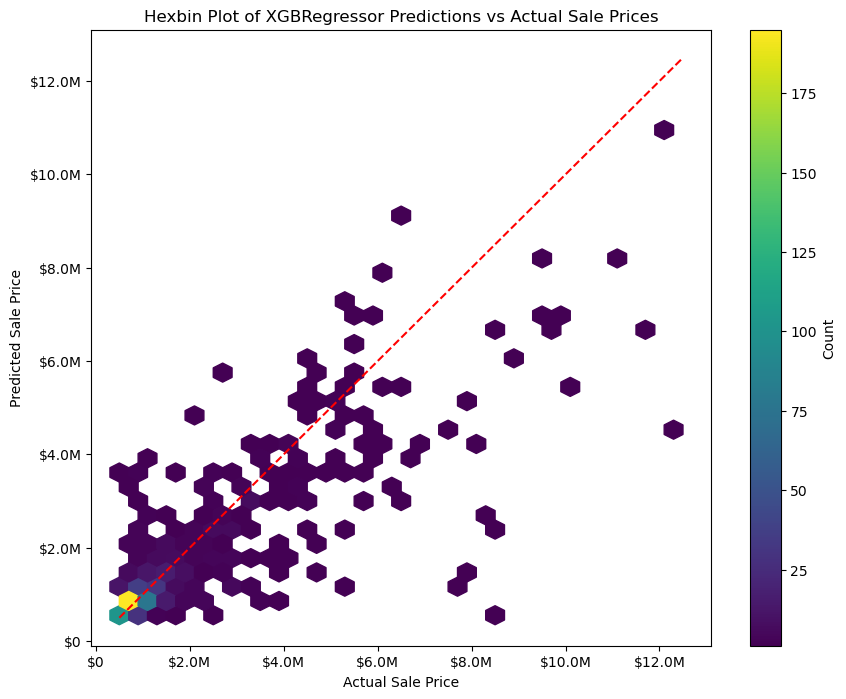

In [1]:
# -----------------------------
# 1. Import Libraries & Load Data
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import xgboost as xgb
import matplotlib.ticker as ticker

# Adjust file path as needed
file_path = "../data/commericalnj.csv"
df = pd.read_csv(file_path, low_memory=False)

# -----------------------------
# 2. Data Cleaning & Time Feature Extraction
# -----------------------------
# Convert 'Sale Date' to datetime and extract time features.
df.loc[:, 'Sale Date'] = pd.to_datetime(df.loc[:, 'Sale Date'], errors='coerce')
df.loc[:, 'Sale Year'] = df.loc[:, 'Sale Date'].apply(lambda x: x.year if pd.notnull(x) else np.nan)
df.loc[:, 'Sale Month'] = df.loc[:, 'Sale Date'].apply(lambda x: x.month if pd.notnull(x) else np.nan)

# Create cyclic features for Sale Month to capture seasonality.
df.loc[:, 'Sale Month Sine'] = np.sin(2 * np.pi * df.loc[:, 'Sale Month'] / 12)
df.loc[:, 'Sale Month Cosine'] = np.cos(2 * np.pi * df.loc[:, 'Sale Month'] / 12)

# Convert key numeric columns to numbers.
numeric_cols = ['Sq. Ft.', 'Yr. Built', 'Acreage', 'Latitude', 'Longitude', 'Sale Price',
                'Total Assmnt', 'Taxes 1']
for col in numeric_cols:
    df.loc[:, col] = pd.to_numeric(df.loc[:, col], errors='coerce')

# -----------------------------
# 3. Remove Irregular Transactions & Extreme Outliers
# -----------------------------
# First, filter out transactions with a sale price below $500,000.
threshold_min = 500000
df_market = df[df['Sale Price'] >= threshold_min].copy()

# Now, remove extreme outliers. For example, remove properties above the 95th percentile.
upper_threshold = df_market['Sale Price'].quantile(0.95)
df_market = df_market[df_market['Sale Price'] <= upper_threshold].copy()

# -----------------------------
# 4. Feature Engineering on the Cleaned DataFrame
# -----------------------------
# Define the key columns to use. Include additional features.
selected_cols = ['Sq. Ft.', 'Yr. Built', 'Acreage', 'Sale Year', 'Sale Month Sine', 'Sale Month Cosine',
                 'Latitude', 'Longitude', 'Sale Price', 'Municipality', 'Property Class', 'Type/Use',
                 'Total Assmnt', 'Taxes 1', 'Neigh']
df_market = df_market.dropna(subset=selected_cols).copy()

# Create a derived feature: Building Age (current year minus Yr. Built)
current_year = pd.Timestamp.today().year
df_market.loc[:, 'Building Age'] = current_year - df_market.loc[:, 'Yr. Built']

# Create the target variable: apply a log transformation on Sale Price to reduce skewness.
df_market.loc[:, 'Log Sale Price'] = np.log1p(df_market.loc[:, 'Sale Price'])

# -----------------------------
# 5. Define Feature Sets and Split Data
# -----------------------------
# Numerical features (continuous values)
numerical_features = ['Sq. Ft.', 'Acreage', 'Building Age', 'Sale Year', 'Sale Month Sine', 'Sale Month Cosine',
                      'Latitude', 'Longitude', 'Total Assmnt', 'Taxes 1']

# Categorical features (non-numeric values)
categorical_features = ['Municipality', 'Property Class', 'Type/Use', 'Neigh']

# Final feature list and target variable
features = numerical_features + categorical_features
target = 'Log Sale Price'

X = df_market.loc[:, features]
y = df_market.loc[:, target]

# Split the data into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 6. Create a Preprocessing Pipeline
# -----------------------------
# For numerical features, apply StandardScaler; for categorical features, apply OneHotEncoder.
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# -----------------------------
# 7. Build the Model Pipeline with XGBoost
# -----------------------------
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# -----------------------------
# 8. Hyperparameter Tuning with GridSearchCV
# -----------------------------
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf,
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

best_params = grid_search.best_params_
cv_rmse = -grid_search.best_score_  # RMSE on the log-transformed target
best_estimator = grid_search.best_estimator_

print("Best Params for XGBRegressor:", best_params)
print(f"CV RMSE for XGBRegressor (log scale): {cv_rmse:.4f}")
print(f"Training Time: {elapsed_time:.2f} sec")

# -----------------------------
# 9. Model Evaluation on Test Set (Back-Transformed)
# -----------------------------
# Predict on the training and test sets (predictions are in log scale).
y_train_pred_log = best_estimator.predict(X_train)
y_test_pred_log = best_estimator.predict(X_test)

# Convert predictions back to the original sale price scale.
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print("\nModel Evaluation on Test Set (back-transformed to sale price scale):")
print(f"Training RMSE: {train_rmse:,.2f} | Test RMSE: {test_rmse:,.2f}")
print(f"Training R^2: {train_r2:.2f} | Test R^2: {test_r2:.2f}")

# -----------------------------
# 10. Plot Predicted vs. Actual Sale Prices with Abbreviated Axes
# -----------------------------
plt.figure(figsize=(10, 8))
plt.hexbin(y_test_actual, y_test_pred, gridsize=30, cmap='viridis', mincnt=1)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Hexbin Plot of XGBRegressor Predictions vs Actual Sale Prices")

ax = plt.gca()
def millions_formatter(x, pos):
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    else:
        return f'${x:.0f}'
formatter = ticker.FuncFormatter(millions_formatter)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
cb = plt.colorbar()
cb.set_label('Count')

plt.show()


# Commercial Property Price Prediction Using XGBoost

This notebook implements an end-to-end pipeline to predict commercial property sale prices. The workflow includes data import, cleaning, feature engineering, splitting the data, building a preprocessing pipeline, model training with hyperparameter tuning using GridSearchCV, model evaluation (with predictions back-transformed to the original sale price scale), and visualization of the results.

---

## 1. Import Libraries & Load Data

We start by importing all necessary libraries for data processing, model training, evaluation, and visualization. The dataset is loaded from a CSV file.

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import xgboost as xgb
import matplotlib.ticker as ticker

# Adjust file path as needed
file_path = "../data/commericalnj.csv"
df = pd.read_csv(file_path, low_memory=False)
```

---

## 2. Data Cleaning & Time Feature Extraction

Here, we convert the "Sale Date" column to datetime and extract the sale year and month. Cyclic features (sine and cosine) are created for the sale month to capture seasonality. We also convert key numeric columns to numeric types.

```python
# Convert 'Sale Date' to datetime and extract time features.
df.loc[:, 'Sale Date'] = pd.to_datetime(df.loc[:, 'Sale Date'], errors='coerce')
df.loc[:, 'Sale Year'] = df.loc[:, 'Sale Date'].apply(lambda x: x.year if pd.notnull(x) else np.nan)
df.loc[:, 'Sale Month'] = df.loc[:, 'Sale Date'].apply(lambda x: x.month if pd.notnull(x) else np.nan)

# Create cyclic features for Sale Month.
df.loc[:, 'Sale Month Sine'] = np.sin(2 * np.pi * df.loc[:, 'Sale Month'] / 12)
df.loc[:, 'Sale Month Cosine'] = np.cos(2 * np.pi * df.loc[:, 'Sale Month'] / 12)

# Convert key numeric columns to numbers.
numeric_cols = ['Sq. Ft.', 'Yr. Built', 'Acreage', 'Latitude', 'Longitude', 'Sale Price', 'Total Assmnt', 'Taxes 1']
for col in numeric_cols:
    df.loc[:, col] = pd.to_numeric(df.loc[:, col], errors='coerce')
```

---

## 3. Remove Irregular Transactions & Extreme Outliers

We filter out transactions with a sale price below \$500,000 and remove extreme outliers by keeping only properties at or below the 95th percentile of the sale price.

```python
# Filter out transactions with a sale price below $500,000.
threshold_min = 500000
df_market = df[df['Sale Price'] >= threshold_min].copy()

# Remove extreme outliers: keep properties at or below the 95th percentile.
upper_threshold = df_market['Sale Price'].quantile(0.95)
df_market = df_market[df_market['Sale Price'] <= upper_threshold].copy()
```

---

## 4. Feature Engineering on the Cleaned DataFrame

We select the key columns and drop rows missing any of these columns. Then, we create additional features:
- **Building Age**: Calculated as the current year minus the year built.
- **Log Sale Price**: The target variable is log-transformed to reduce skewness.

```python
# Define the key columns to use.
selected_cols = ['Sq. Ft.', 'Yr. Built', 'Acreage', 'Sale Year', 'Sale Month Sine', 'Sale Month Cosine',
                 'Latitude', 'Longitude', 'Sale Price', 'Municipality', 'Property Class', 'Type/Use',
                 'Total Assmnt', 'Taxes 1', 'Neigh']
df_market = df_market.dropna(subset=selected_cols).copy()

# Create a derived feature: Building Age.
current_year = pd.Timestamp.today().year
df_market.loc[:, 'Building Age'] = current_year - df_market.loc[:, 'Yr. Built']

# Create the target variable: Log Sale Price.
df_market.loc[:, 'Log Sale Price'] = np.log1p(df_market.loc[:, 'Sale Price'])
```

---

## 5. Define Feature Sets and Split Data

We define our numerical and categorical features, combine them into a final feature set, and split the dataset into training (80%) and testing (20%) sets.

```python
# Define numerical features.
numerical_features = ['Sq. Ft.', 'Acreage', 'Building Age', 'Sale Year', 'Sale Month Sine', 'Sale Month Cosine',
                      'Latitude', 'Longitude', 'Total Assmnt', 'Taxes 1']

# Define categorical features.
categorical_features = ['Municipality', 'Property Class', 'Type/Use', 'Neigh']

# Final feature list and target variable.
features = numerical_features + categorical_features
target = 'Log Sale Price'

X = df_market.loc[:, features]
y = df_market.loc[:, target]

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

---

## 6. Create a Preprocessing Pipeline

We build a preprocessing pipeline using `ColumnTransformer` to scale numerical features and one-hot encode categorical features.

```python
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
```

---

## 7. Build the Model Pipeline with XGBoost

The model pipeline combines the preprocessing steps with an XGBoost regressor.

```python
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])
```

---

## 8. Hyperparameter Tuning with GridSearchCV

We define a hyperparameter grid and use 5-fold cross-validation to tune the XGBoost model.

```python
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf,
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

best_params = grid_search.best_params_
cv_rmse = -grid_search.best_score_  # RMSE on the log-transformed target
best_estimator = grid_search.best_estimator_

print("Best Params for XGBRegressor:", best_params)
print(f"CV RMSE for XGBRegressor (log scale): {cv_rmse:.4f}")
print(f"Training Time: {elapsed_time:.2f} sec")
```

---

## 9. Model Evaluation on Test Set (Back-Transformed)

We evaluate the model by predicting on both the training and testing sets, converting the log-scale predictions back to the original sale price scale, and then calculating RMSE and R² metrics.

```python
# Predict on the training and test sets.
y_train_pred_log = best_estimator.predict(X_train)
y_test_pred_log = best_estimator.predict(X_test)

# Convert predictions back to the original sale price scale.
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print("\nModel Evaluation on Test Set (back-transformed to sale price scale):")
print(f"Training RMSE: {train_rmse:,.2f} | Test RMSE: {test_rmse:,.2f}")
print(f"Training R^2: {train_r2:.2f} | Test R^2: {test_r2:.2f}")
```

---

## 10. Plot Predicted vs. Actual Sale Prices with Abbreviated Axes

Finally, we create a hexbin plot to visualize how well the model predicts sale prices. The axes are formatted to display dollar amounts in an abbreviated format.

```python
plt.figure(figsize=(10, 8))
plt.hexbin(y_test_actual, y_test_pred, gridsize=30, cmap='viridis', mincnt=1)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Hexbin Plot of XGBRegressor Predictions vs Actual Sale Prices")

ax = plt.gca()
def millions_formatter(x, pos):
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    else:
        return f'${x:.0f}'
formatter = ticker.FuncFormatter(millions_formatter)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
cb = plt.colorbar()
cb.set_label('Count')

plt.show()
```
